## Prepare files

In [ ]:
import numpy as np
import glob
import os

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [2]:
root_dir = "/home/bumblebee/Desktop/NATOhackathon/DroneRFb-Spectra2/S3R-main/Data"   # adjust path
files = []
labels = []

for class_id in sorted(os.listdir(root_dir)):
    class_path = os.path.join(root_dir, class_id)
    if not os.path.isdir(class_path):
        continue
    for f in glob.glob(os.path.join(class_path, "*.npy")):
        files.append(f)
        labels.append(int(class_id))  # folder name = label

files = np.array(files)
labels = np.array(labels)
print(f"Total files: {len(files)}, labels: {len(labels)}")

Total files: 14484, labels: 14484


float16
(543, 512)


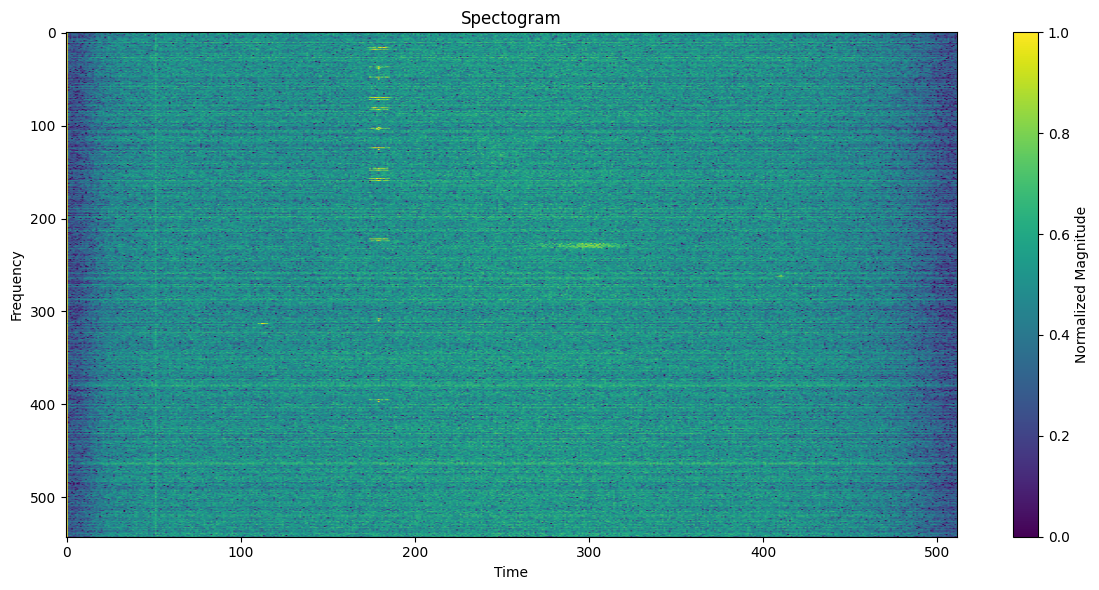

In [4]:
## Visualize a sample spectrogram

data = np.load('/home/bumblebee/Desktop/NATOhackathon/DroneRFb-Spectra2/S3R-main/Data/0/3-a.npy')

print(data.dtype) # float16

print(data.shape) # (543, 512)

# Normalize each sample -> better contrast
data_norm = (data - data.min(axis=1, keepdims=True)) / (data.max(axis=1, keepdims=True) - data.min(axis=1, keepdims=True) + 1e-8)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(data_norm, aspect='auto', cmap='viridis')  
plt.title('Spectogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Normalized Magnitude')
plt.tight_layout()
plt.show()

## Labeling

This dataset is already labeled, the folder name is the class.

Testing both clustering and Label propagation techniques

In [3]:
# Flatten and normalize
features = []
for f in files:
    spec = np.load(f).astype(np.float32)
    spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-8)
    features.append(spec.flatten())
features = np.array(features)

In [4]:
subset_per_class = 100 

subset_idx = []

for c in np.unique(labels):
    class_idx = np.where(labels == c)[0]
    chosen = np.random.choice(class_idx, min(subset_per_class, len(class_idx)), replace=False)
    subset_idx.extend(chosen)

subset_idx = np.array(subset_idx)
subset_features = features[subset_idx]
subset_labels = labels[subset_idx]

In [ ]:
# too many features (512 x 543) rduce dim to 50
# could also test a small CNN to extract features
# PCA actually improved label propagation from 4% to 60% accuracy
features_pca = PCA(n_components=50).fit_transform(subset_features)

In [5]:
# 30% labeled
labeled_idx, unlabeled_idx = train_test_split(
    np.arange(len(subset_labels)),
    test_size=0.7,
    stratify=subset_labels,
    random_state=42
)

semi_labels = -1 * np.ones(len(subset_labels), dtype=int)
semi_labels[labeled_idx] = subset_labels[labeled_idx]


In [ ]:
k = len(np.unique(subset_labels))
kmeans = KMeans(n_clusters=k, random_state=42).fit(features_pca)

cluster_labels = np.zeros(k, dtype=int)
for i in range(k):
    members = np.where(kmeans.labels_ == i)[0]
    labeled_members = [semi_labels[m] for m in members if semi_labels[m] != -1]
    if labeled_members:
        cluster_labels[i] = np.bincount(labeled_members).argmax()
    else:
        cluster_labels[i] = -1  # fallback

propagated_labels = np.array([cluster_labels[c] for c in kmeans.labels_])

In [12]:
from sklearn.semi_supervised import LabelPropagation

lp_model = LabelPropagation(kernel='rbf', gamma=0.1, max_iter=1000)
lp_model.fit(features_pca, semi_labels)
propagated_labels_lp = lp_model.transduction_


/home/bumblebee/.venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


In [15]:
from sklearn.metrics import accuracy_score

mask = subset_labels != -1 
acc = accuracy_score(subset_labels[unlabeled_idx], propagated_labels[unlabeled_idx])
acc_lp = accuracy_score(subset_labels[unlabeled_idx], propagated_labels_lp[unlabeled_idx])

print("KMeans propagated accuracy:", acc)
print("LabelPropagation accuracy:", acc_lp)


KMeans propagated accuracy: 0.29583333333333334
LabelPropagation accuracy: 0.6017857142857143


## Cross validation

Fold 0: Train 11587, Val 2897
  Train distribution: {np.int64(0): np.int64(552), np.int64(1): np.int64(552), np.int64(2): np.int64(569), np.int64(3): np.int64(615), np.int64(4): np.int64(588), np.int64(5): np.int64(609), np.int64(6): np.int64(576), np.int64(7): np.int64(588), np.int64(8): np.int64(279), np.int64(9): np.int64(595), np.int64(10): np.int64(384), np.int64(11): np.int64(237), np.int64(12): np.int64(463), np.int64(13): np.int64(315), np.int64(14): np.int64(458), np.int64(15): np.int64(459), np.int64(16): np.int64(444), np.int64(17): np.int64(468), np.int64(18): np.int64(472), np.int64(19): np.int64(456), np.int64(20): np.int64(492), np.int64(21): np.int64(461), np.int64(22): np.int64(468), np.int64(23): np.int64(487)}
Fold 1: Train 11587, Val 2897
  Train distribution: {np.int64(0): np.int64(552), np.int64(1): np.int64(552), np.int64(2): np.int64(568), np.int64(3): np.int64(615), np.int64(4): np.int64(588), np.int64(5): np.int64(609), np.int64(6): np.int64(576), np.int64(7):

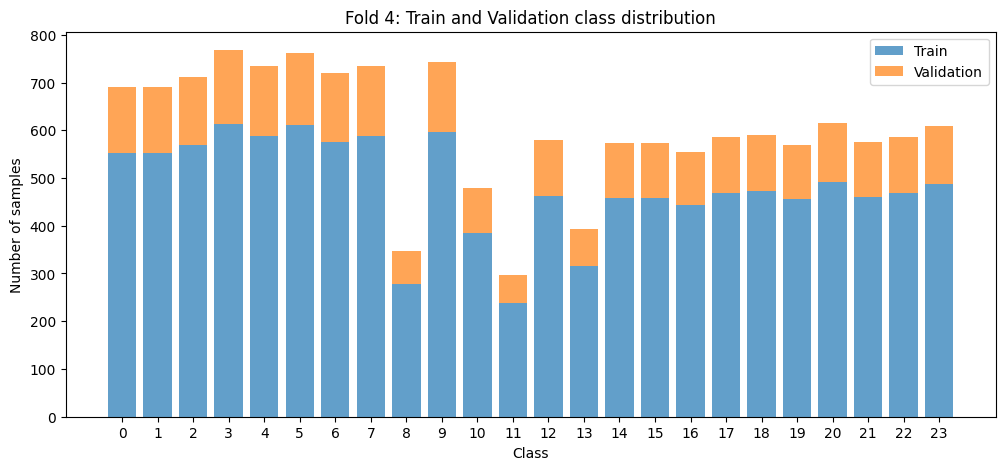

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classes = np.unique(labels)

for fold, (train_idx, val_idx) in enumerate(skf.split(files, labels)):
    train_files, val_files = files[train_idx], files[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Count per class
    train_counts = [np.sum(train_labels == c) for c in classes]
    val_counts = [np.sum(val_labels == c) for c in classes]

    print(f"Fold {fold}: Train {len(train_idx)}, Val {len(val_idx)}")
    print("  Train distribution:", dict(zip(classes, train_counts)))

# Plot
plt.figure(figsize=(12, 5))
plt.bar(classes, train_counts, alpha=0.7, label="Train")
plt.bar(classes, val_counts, alpha=0.7, label="Validation", bottom=train_counts)
plt.xticks(classes)
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title(f"Fold {fold}: Train and Validation class distribution")
plt.legend()
plt.show()

## Dataset class

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = np.load(self.file_paths[idx]).astype(np.float32)  # shape (time, freq)
        # Add channel dimension for CNN: (1, time, freq)
        spec = np.expand_dims(spec, axis=0)
        label = self.labels[idx]

        if self.transform:
            spec = self.transform(spec)

        return torch.tensor(spec), torch.tensor(label)


## CNN Model

The 67*64 in fc1 is based on 3× pooling of 543×512 input

In [7]:
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # flattened size after pooling (input 543x512)
        self.fc1 = nn.Linear(64 * 67 * 64, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16, 271, 256)
        x = self.pool(F.relu(self.conv2(x)))  # (32, 135, 128)
        x = self.pool(F.relu(self.conv3(x)))  # (64, 67, 64)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


## Training

5 epochs is too low for CNNs, but to make it shorter training

In [ ]:
# Training parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
num_epochs = 5
num_folds = 5

# Metrics
fold_metrics = []

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(files, labels)):
    print(f"\n===== Fold {fold} =====")
    train_files, val_files = files[train_idx], files[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Datasets
    train_dataset = SpectrogramDataset(train_files, train_labels)
    val_dataset = SpectrogramDataset(val_files, val_labels)

    # Weighted sampling
    classes_unique = np.unique(train_labels)
    class_weights = compute_class_weight("balanced", classes=classes_unique, y=train_labels)
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model, loss, optimizer
    model = SpectrogramCNN(num_classes=24).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch}: Train Loss = {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    print(f"Fold {fold} → Accuracy: {acc:.4f}, F1-macro: {f1_macro:.4f}, F1-weighted: {f1_weighted:.4f}")
    fold_metrics.append((acc, f1_macro, f1_weighted))

# Average metrics
fold_metrics = np.array(fold_metrics)
print("\n===== Cross-validation summary =====")
print(f"Average Accuracy: {fold_metrics[:,0].mean():.4f} ± {fold_metrics[:,0].std():.4f}")
print(f"Average F1-macro: {fold_metrics[:,1].mean():.4f} ± {fold_metrics[:,1].std():.4f}")
print(f"Average F1-weighted: {fold_metrics[:,2].mean():.4f} ± {fold_metrics[:,2].std():.4f}")



===== Fold 0 =====
Epoch 0: Train Loss = 1.8596
Epoch 1: Train Loss = 0.8594
Epoch 2: Train Loss = 0.6046
Epoch 3: Train Loss = 0.4525
Epoch 4: Train Loss = 0.3503
Fold 0 → Accuracy: 0.8823, F1-macro: 0.8929, F1-weighted: 0.8787

===== Fold 1 =====
Epoch 0: Train Loss = 1.4722
Epoch 1: Train Loss = 0.5240
Epoch 2: Train Loss = 0.3118
Epoch 3: Train Loss = 0.2074
Epoch 4: Train Loss = 0.1489
Fold 1 → Accuracy: 0.9106, F1-macro: 0.9189, F1-weighted: 0.9108

===== Fold 2 =====
Epoch 0: Train Loss = 3.1967
Epoch 1: Train Loss = 3.1782
Epoch 2: Train Loss = 3.1788
Epoch 3: Train Loss = 3.1783
Epoch 4: Train Loss = 3.1784
Fold 2 → Accuracy: 0.0490, F1-macro: 0.0039, F1-weighted: 0.0046

===== Fold 3 =====
Epoch 0: Train Loss = 1.6553
Epoch 1: Train Loss = 0.6648
Epoch 2: Train Loss = 0.4517
Epoch 3: Train Loss = 0.3649
Epoch 4: Train Loss = 0.3026
Fold 3 → Accuracy: 0.8882, F1-macro: 0.8986, F1-weighted: 0.8881

===== Fold 4 =====
Epoch 0: Train Loss = 1.8424
Epoch 1: Train Loss = 0.6021
Ep

In [19]:
# Save model
torch.save(model.state_dict(), "/home/bumblebee/Desktop/NATOhackathon/Implementation/final_model.pth")

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "/home/bumblebee/Desktop/NATOhackathon/Implementation/spectrogram_checkpoint.pth")

## Metrics 

In [13]:
train_files, val_files, train_labels, val_labels = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)

val_dataset = SpectrogramDataset(val_files, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
sgmodel = SpectrogramCNN(num_classes=24)
sgmodel.load_state_dict(torch.load("/home/bumblebee/Desktop/NATOhackathon/Implementation/final_model.pth"))
sgmodel.eval()
all_preds, all_labels = [], []
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = sgmodel(X_batch)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")  # or "macro"

print("Validation Accuracy:", acc)
print("Validation F1 Score:", f1)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))


Validation Accuracy: 0.9157749395926821
Validation F1 Score: 0.9141701753330751

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.61      0.73       138
           1       0.95      0.91      0.93       138
           2       0.90      0.79      0.84       142
           3       0.62      0.94      0.75       154
           4       0.71      0.95      0.82       147
           5       1.00      0.99      1.00       152
           6       1.00      1.00      1.00       144
           7       0.91      0.50      0.64       147
           8       0.99      1.00      0.99        69
           9       0.98      0.99      0.99       149
          10       1.00      1.00      1.00        96
          11       0.98      1.00      0.99        59
          12       1.00      1.00      1.00       116
          13       1.00      1.00      1.00        79
          14       0.91      1.00      0.95       115
          15       1.00      0

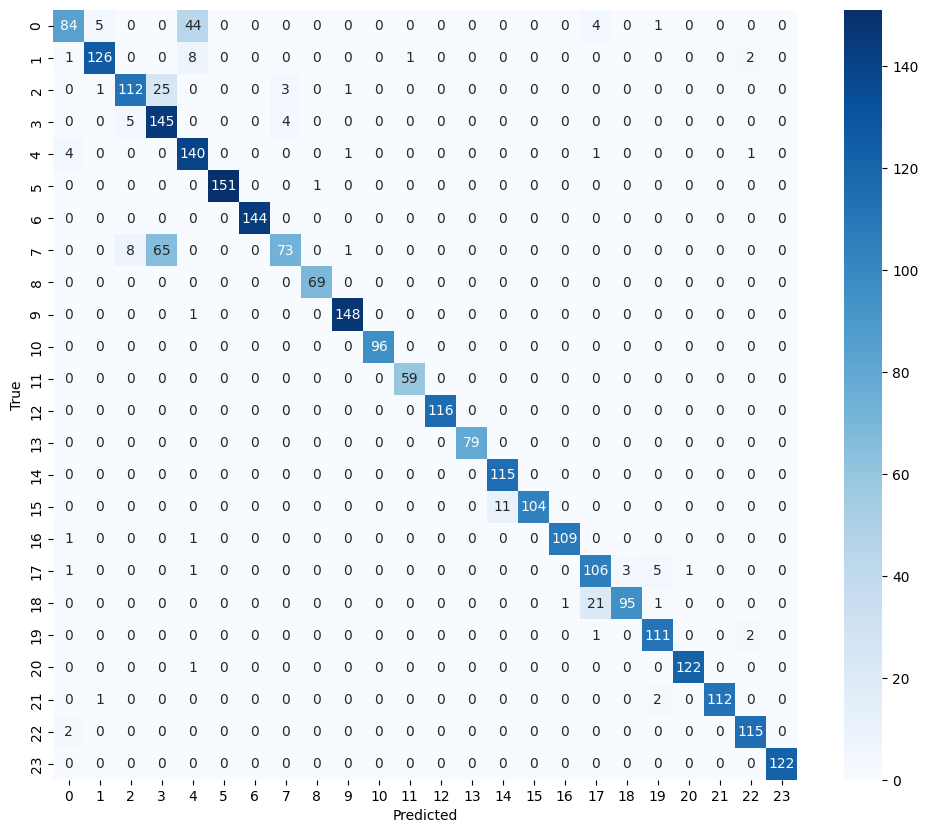

In [18]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()